In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook

plt.style.use('seaborn-ticks')
from matplotlib import pyplot as plt
import seaborn as sns
from fklab.io.data import import_position
from fklab.io.data import import_environment
import fklab.geometry.utilities

from fklab.signals.smooth import kernelsmoothing
from fklab.behavior import task_analysis

from data_analysis import loading

In [23]:
loading.load_project('/media/kasia/K/Neuropixeldata/LS_k_5/catgt_14032020-b0_g0')
loading.load_cluster()
ls_data = loading.cluster_data
loading.load_position('/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-14_13-02-19/epochs/training/position.hdf5')
loading.load_position_yaml()
loading.load_environment_yaml()
loading.load_kilosort()
loading.load_event('/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-14_13-02-19/Events.nev',)

In [24]:
time_shift = -5
Fs=3000

In [25]:
position_time = np.array(loading.position_time)
corrected_time = position_time + time_shift
corrected_time

array([2326.004069, 2326.044189, 2326.083729, ..., 5281.618655,
       5281.658753, 5281.699314])

In [26]:
#loading spiking data
project_root = '/media/kasia/K/Neuropixeldata/LS_k_5/catgt_14032020-b0_g0/'

clusters = np.load(project_root + "spike_clusters.npy")
# print(clusters)
spike_times = np.load(project_root + "spike_times.npy") / Fs
#print(spike_times)
spike_templates = np.load(project_root + "templates.npy")

y_coords = np.load(project_root + "channel_positions.npy")
#print(y_coords)
spike_clusters = np.load(project_root + "spike_clusters.npy")

In [27]:
#loading clusters 
dtype = np.dtype([
    ('id', np.int),
    ('Amplitude', np.float),
    ('ContamPct', np.float),
    ('KSLabel', np.dtype('U5')),
    ('amp', np.float),
    ('channel', np.int),
    ('depth', np.float),
    ('firing_rate', np.float),
    ('group', np.dtype('U5')),
    ('n_spikes', np.int),
    ('shank', np.int),
])

data = np.loadtxt(project_root + "cluster_info.tsv",
                 dtype=dtype, skiprows=1, delimiter='\t',
                 converters={7:lambda fr: fr.replace(b' spk/s', b'')})
#print(data[data['KSLabel'] == 'good'])
# data_good = data[data['KSLabel']== 'good']
data_good = data[data['group'] == 'good']


In [28]:
depth = data_good['depth']
n_spk = data_good['n_spikes']
id_s = data_good['id']
channel= data_good['channel']


In [29]:
epoch = loading.position_yaml['source']['epoch']
epoch
open_field_epoch = [2331, 3515]
Y_maze_epoch = [3533, 5230]
t_at = corrected_time[np.logical_and(corrected_time > Y_maze_epoch[0], corrected_time < Y_maze_epoch[1])]

In [30]:
from fklab.geometry.shapes import rectangle
open_field_data = loading.environment_yaml['open_field']['shapes']['open_field']['shape']
open_field = rectangle(**open_field_data)


In [31]:
from fklab.geometry.shapes import graph, polyline
Y_maze_data = loading.environment_yaml['AT']['shapes']['AT']['shape']
Y_maze_data['polylines'] = [polyline(**p) if not isinstance(p, polyline) else p for p in Y_maze_data['polylines']]
Y_maze = graph(**Y_maze_data)
# print(Y_maze)
left_arm_d = loading.environment_yaml['AT']['shapes']['left_arm']['shape']
left_arm = polyline(**left_arm_d)
# left_arm
right_arm_d = loading.environment_yaml['AT']['shapes']['left_arm']['shape']
right_arm = polyline(**right_arm_d)
right_arm

straight polyline with 2 vertices

In [45]:
position_at = loading.position[np.logical_and(corrected_time > Y_maze_epoch[0],
                                      corrected_time < Y_maze_epoch[1]), :]
position_at_cm = position_at * 0.27

position_of = loading.position[np.logical_and(corrected_time > open_field_epoch[0],
                                      corrected_time < open_field_epoch[1]), :]
position_of_cm = position_of * 0.27

In [33]:
import scipy.interpolate
# set evaluation grid resolution
fine_grid_resolution = 2.; # cm, spatial grid used to build squared distance matrix
grid_resolution = 4.; # cm, spatial grid for decoding (should be multiple of fine grid)

# set behavior options
stim_sampling_frequency = 25. # Hz, sampling frequency of position tracking
speed_threshold = 10. # cm/s, only use data when animal runs faster than speed threshold for building encoding model

m = ~np.logical_or(np.isnan(position_at[:, 0]), np.isnan(position_at[:, 1]))
position_at = position_at[m, :]
t_at = t_at[m]
# construct fine grid for complete track and compute squared distance matrix
fine_grid = np.arange( 0, Y_maze.pathlength, fine_grid_resolution )
fine_gridx, fine_gridy = np.meshgrid( fine_grid, fine_grid )
distances = Y_maze.distance( fine_gridx, fine_gridy )**2


# map all xy positions to maze
linear_pos =Y_maze.point2path(position_at)[0]
linear_pos_cm = linear_pos * 0.27
# map linearized positions to the fine grid vector
pos = scipy.interpolate.interp1d(fine_grid, np.arange(len(fine_grid)), kind='nearest', bounds_error=False)(linear_pos)

# # create nearest neighbor interpolators for mapped positions for future use
linear_pos_interpolator = scipy.interpolate.interp1d(t_at, linear_pos, kind='nearest', bounds_error=False )
pos_interpolator = scipy.interpolate.interp1d(t_at, pos, kind='nearest', bounds_error=False )

import fklab.signals.smooth.kernelsmoothing as ks
linear_vel = Y_maze.gradient(linear_pos_cm, 1/stim_sampling_frequency)
linear_vel = ks.smooth1d(linear_vel, bandwidth=0.5, delta=1/stim_sampling_frequency)
run_dir = (linear_vel>0).astype(np.float) 
dir_interpolator = scipy.interpolate.interp1d(t_at, run_dir, kind='nearest', bounds_error=False)

<IPython.core.display.Javascript object>


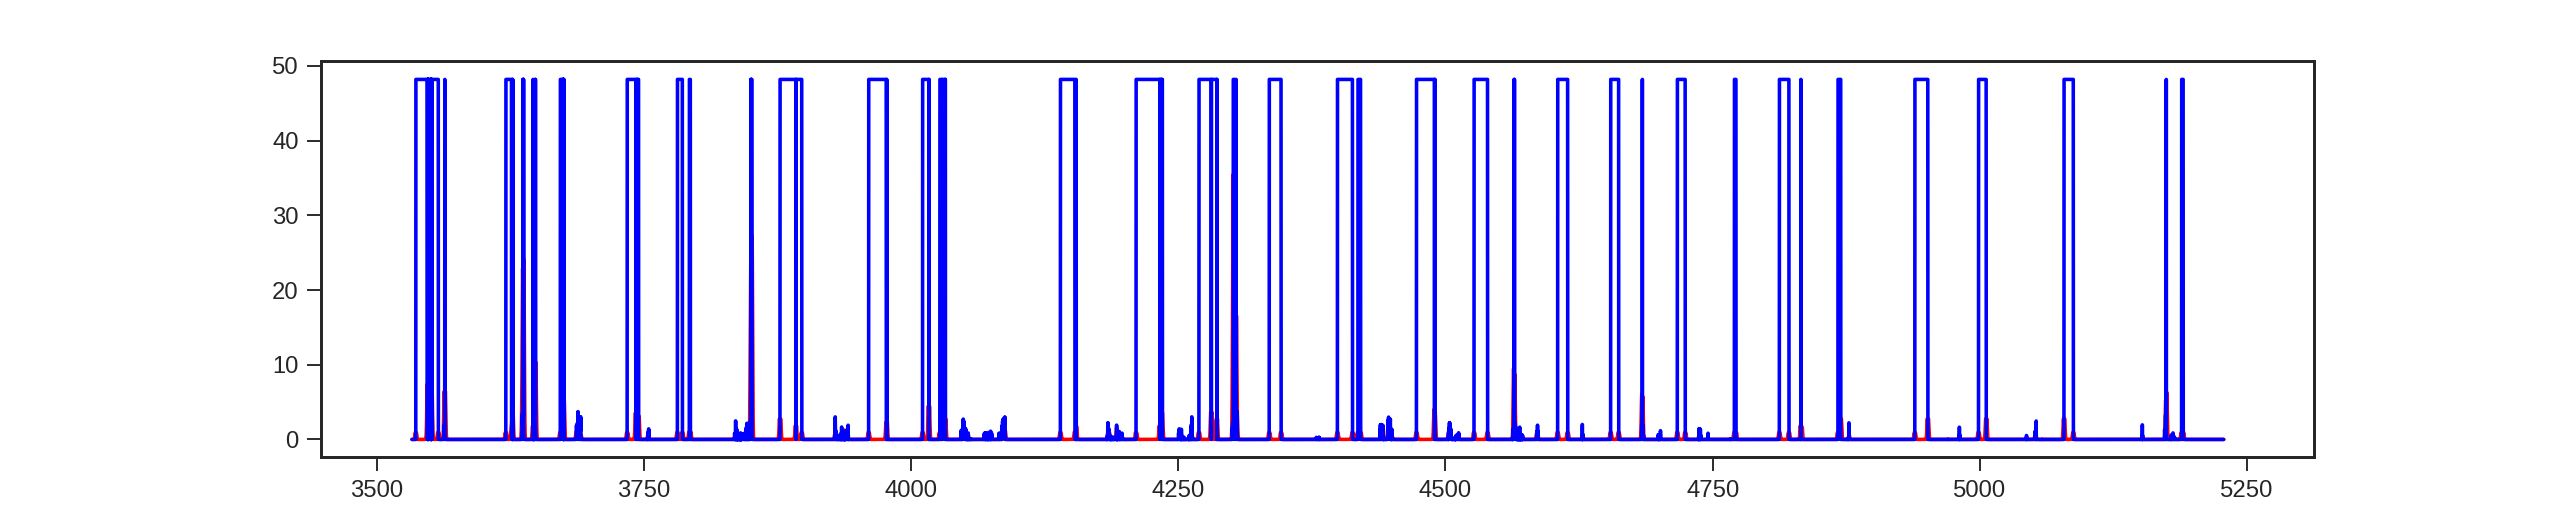

In [34]:
# double check linear position and velocity
plt.figure(figsize=(15,3))
plt.plot(t_at, abs(linear_vel), 'r')
plt.plot(t_at, linear_pos_cm, 'b')


<IPython.core.display.Javascript object>


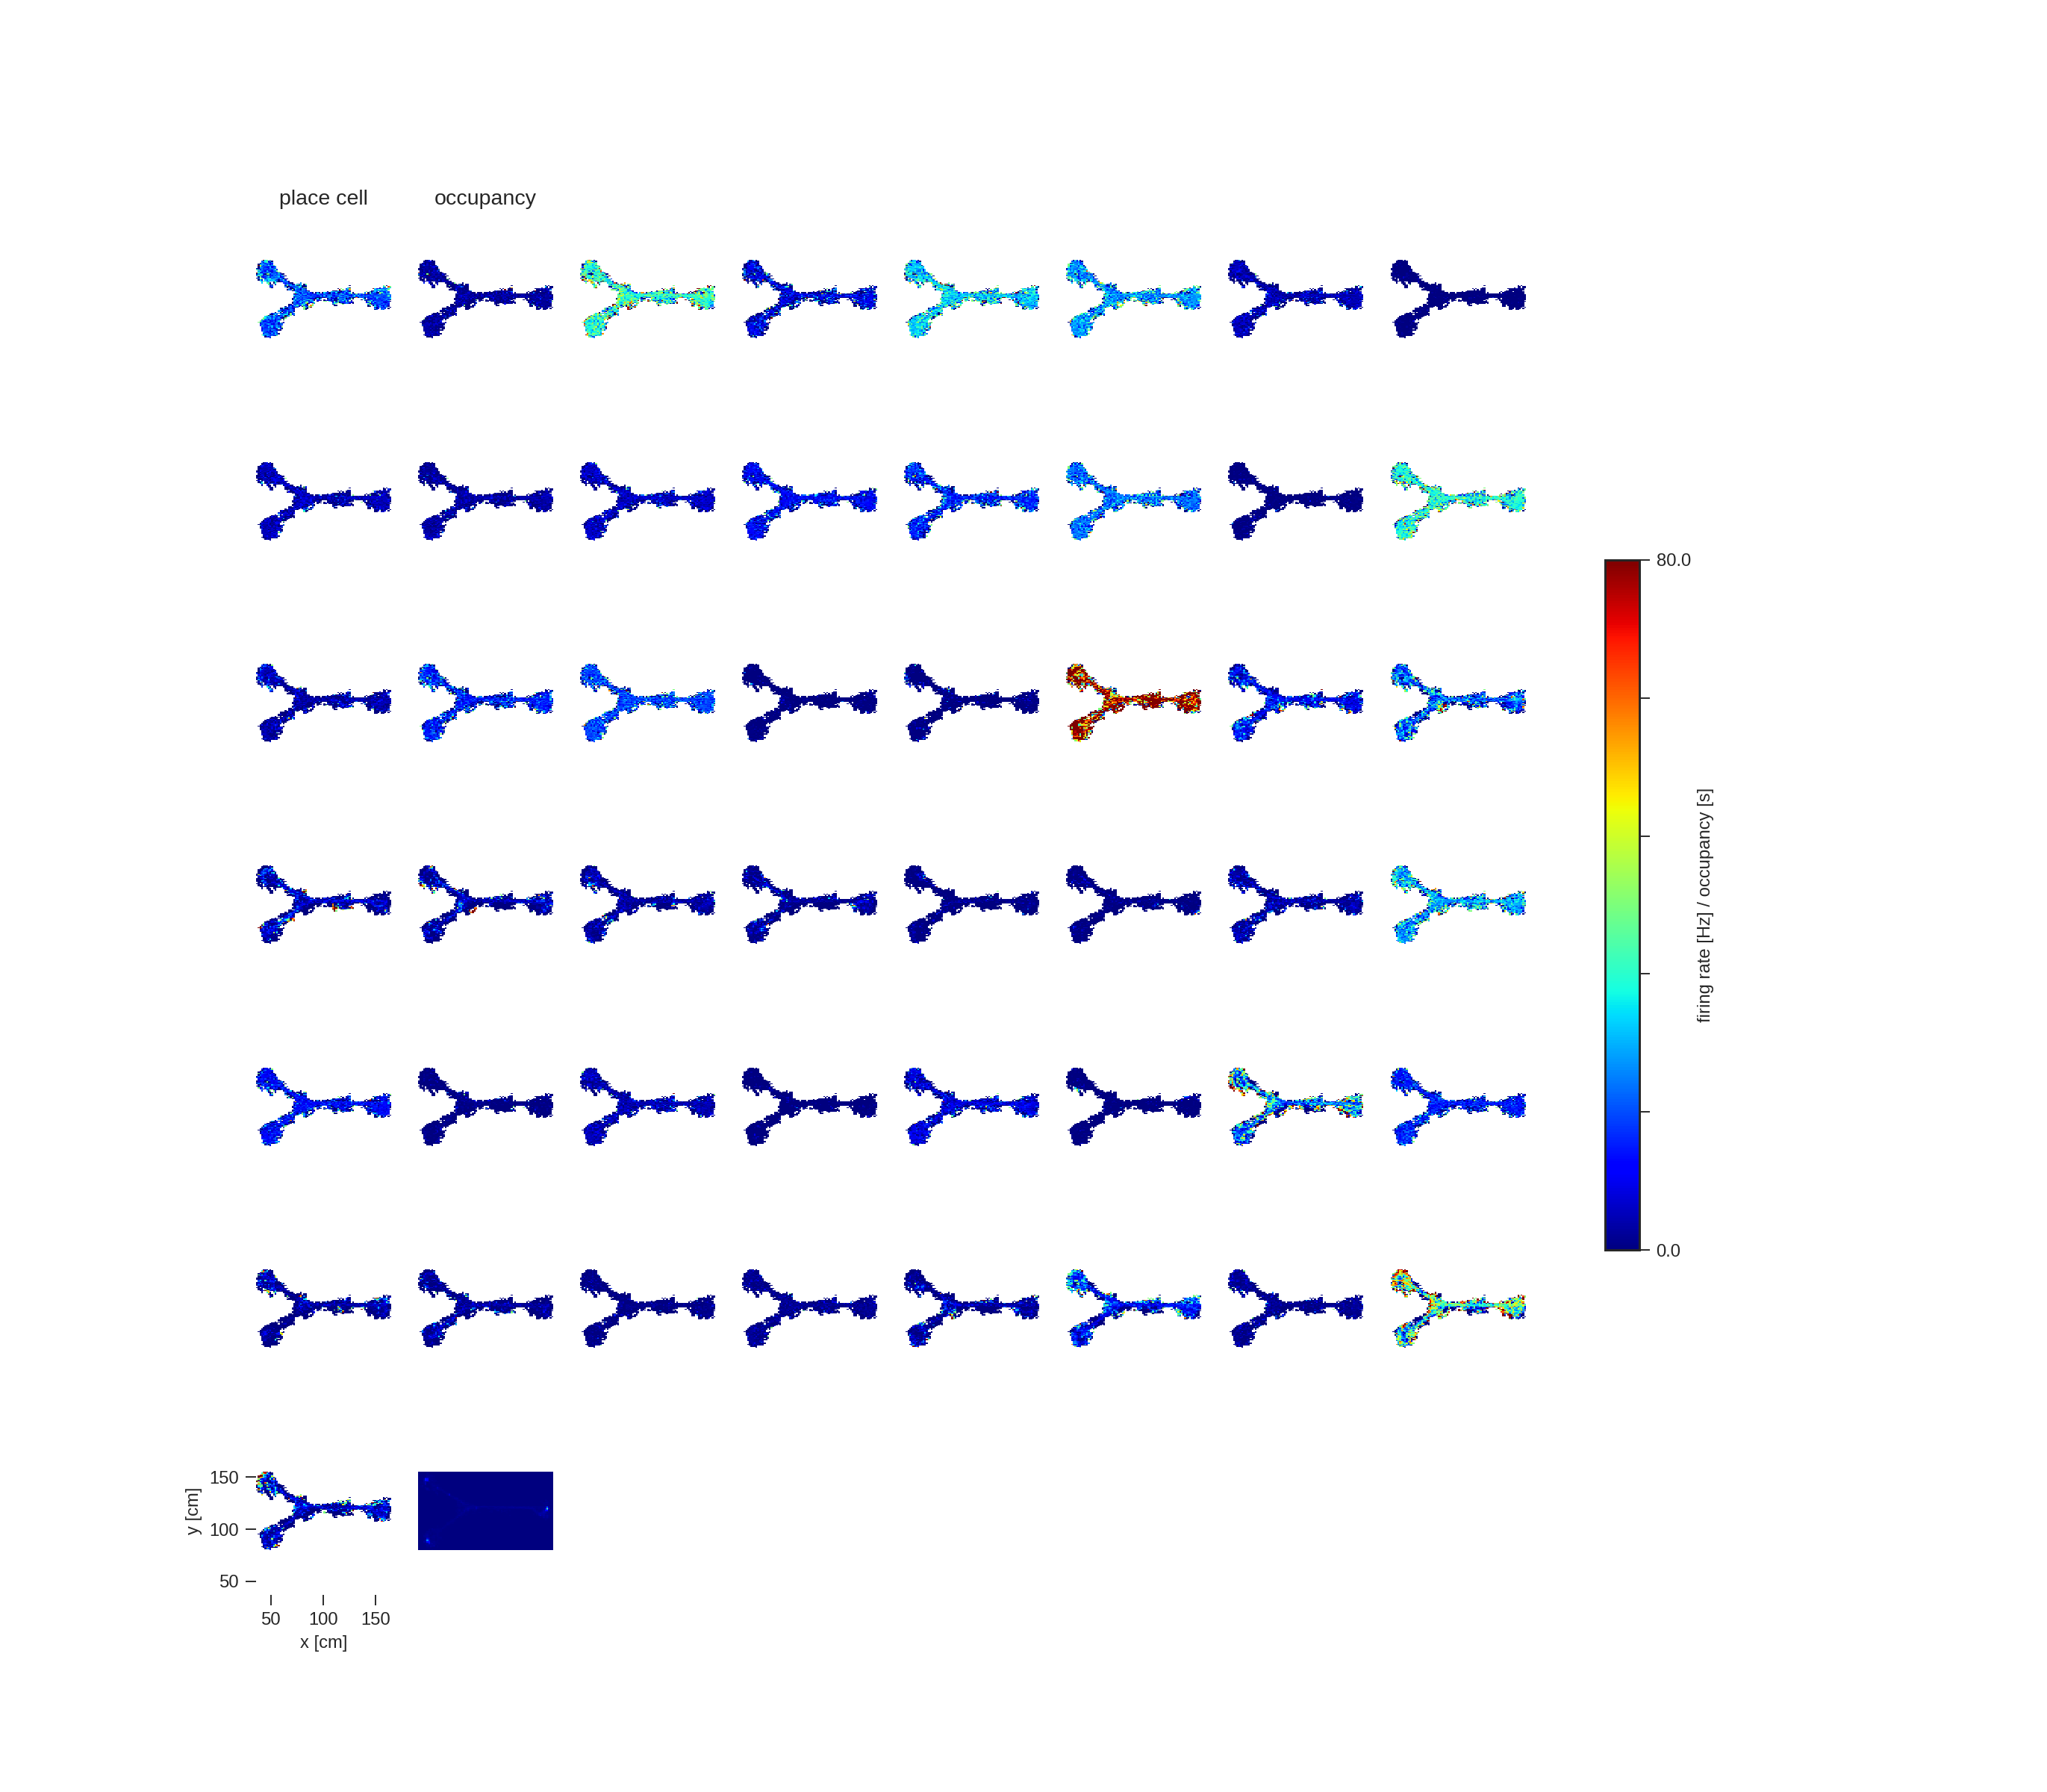

In [35]:
from os import path
from fklab.signals.smooth import create_smoother
import fklab.ratemap as rm
from fklab.plot.plots import plot_2d_maps

outpath = '/media/kasia/K/Neuropixeldata/LS_k_5/14_03_20_plots'

cluster_channel = pd.read_csv('/media/kasia/K/Neuropixeldata/data_analysis/Cluster_channel_LS_K_5_140320.tsv', sep='\t')
ks_spike_times = loading.ks_spike_times[:, 0]
spike_time_rangeat = np.array(Y_maze_epoch) - loading.evt_start_time[1] + time_shift
spike_t = {}
for cl in cluster_channel['cluster']:
    spike_xat = ks_spike_times[loading.get_spike_seq(spike_time_rangeat, cluster_list=[cl] )] + loading.evt_start_time[1]

    spike_t[cl]=spike_xat
    
linear_posat = Y_maze.point2path(position_at_cm)[0]
t_at = corrected_time[np.logical_and(corrected_time > Y_maze_epoch[0], corrected_time < Y_maze_epoch[1])]
event = {key: rm.compute_variable_at_times(z, variable=position_at_cm, var_t=t_at) for key, z in spike_t.items()}

eventat = list(event.values())
rmap_hist, _, occ_hist, binedges = rm.hist.ratemap(
    *eventat,
    stimdata = position_at_cm,
    stimduration=1/40,
#     smooth = 5,
#     valid = in_circle(50),
    bins = 80)
 

fig, axes = plot_2d_maps(
        [*rmap_hist,occ_hist],
        coordinates=binedges,
        cmap='jet',
        xlabel="x [cm]",
        ylabel="y [cm]",
        colorlabel="firing rate [Hz] / occupancy [s]",
        cbar=True,
        grid=(None),
#         figsize=(14,3.5),
        axsize=(2,2),
        cmin=0, cmax=80,
        roundto=.5,
        cbar_kw=dict(shrink=0.5)
        )
    
axes[0,0].set(title='place cell')
axes[0,1].set(title='occupancy');

for ax in axes.ravel():
        ax.set_frame_on(False)
        ax.axis('equal')

# plt.savefig("ATratemap1403201D.png")

<IPython.core.display.Javascript object>


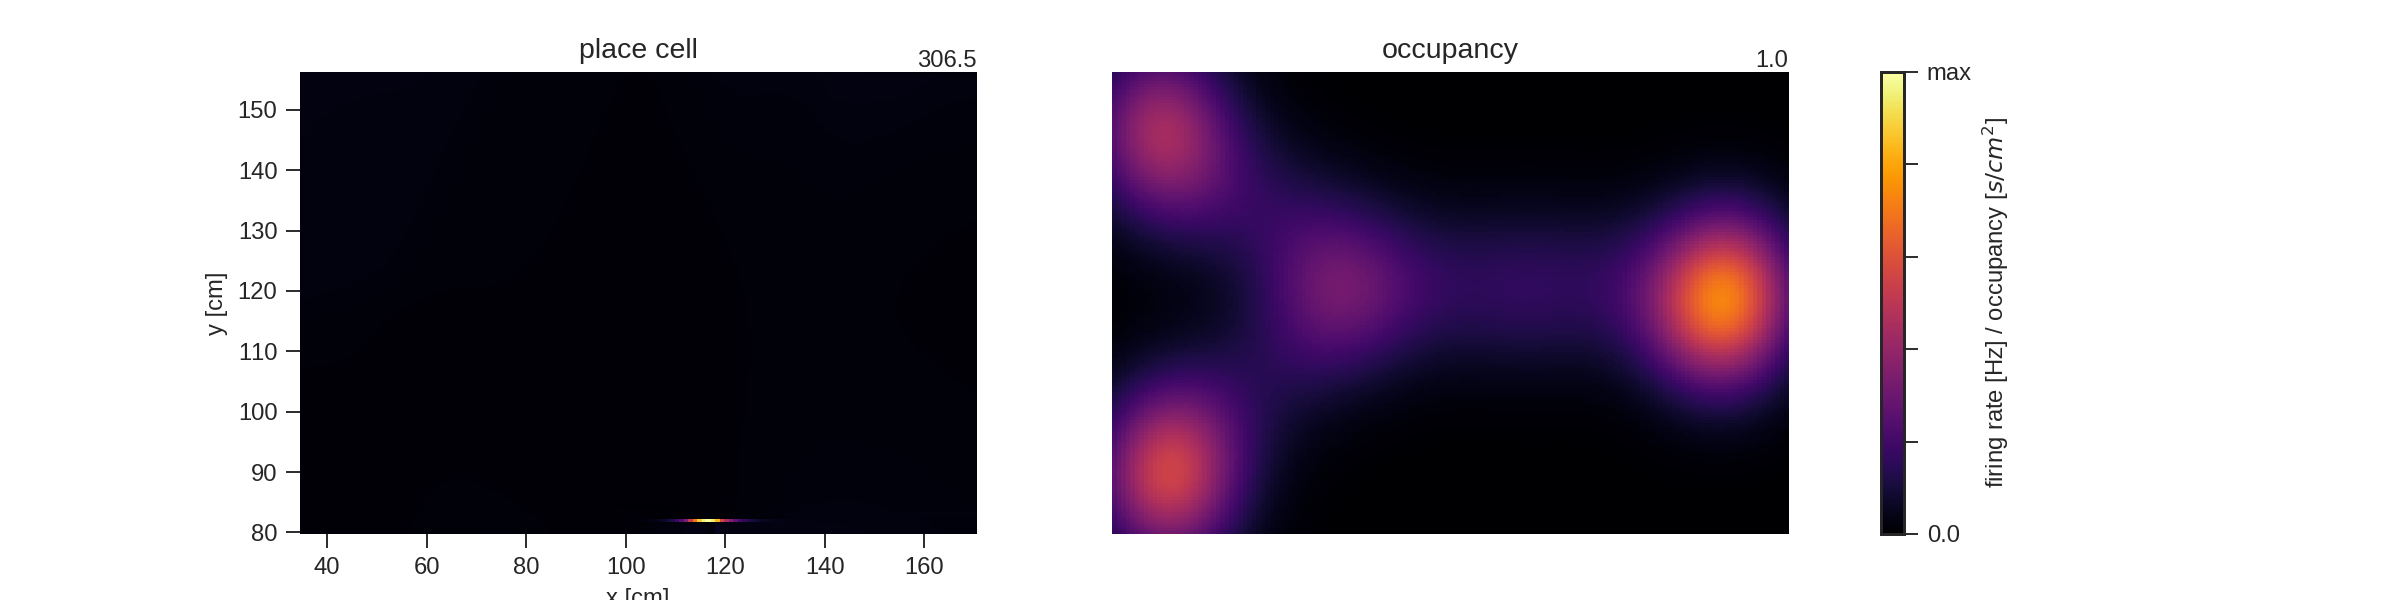

In [34]:
rmap, _, occ, samplegrid = rm.kde.linear_2d_tuning(
    spike_xat, 
    xy = position_at_cm,
    t = t_at,
    bandwidth = 9.,
    grid = [np.linspace(35,170,150), np.linspace(80,156,150)],
#     valid = in_circle(radius=50),
    compression=1.)


fig, axes = plot_2d_maps(
    [*rmap,occ],
    coordinates=samplegrid,
    cmap='inferno',
    xlabel="x [cm]",
    ylabel="y [cm]",
    colorlabel="firing rate [Hz] / occupancy [$s/cm^2$]",
    cbar=True,
    grid=(1,2),
    figsize=(14,3.5),
    cmin=0, cmax='auto',
    roundto=.5
)

axes[0,0].set(title='place cell')
# axes[0,1].set(title='heading cell')
axes[0,1].set(title='occupancy');

for ax in axes[0,:]:
    ax.set_frame_on(False)



<IPython.core.display.Javascript object>


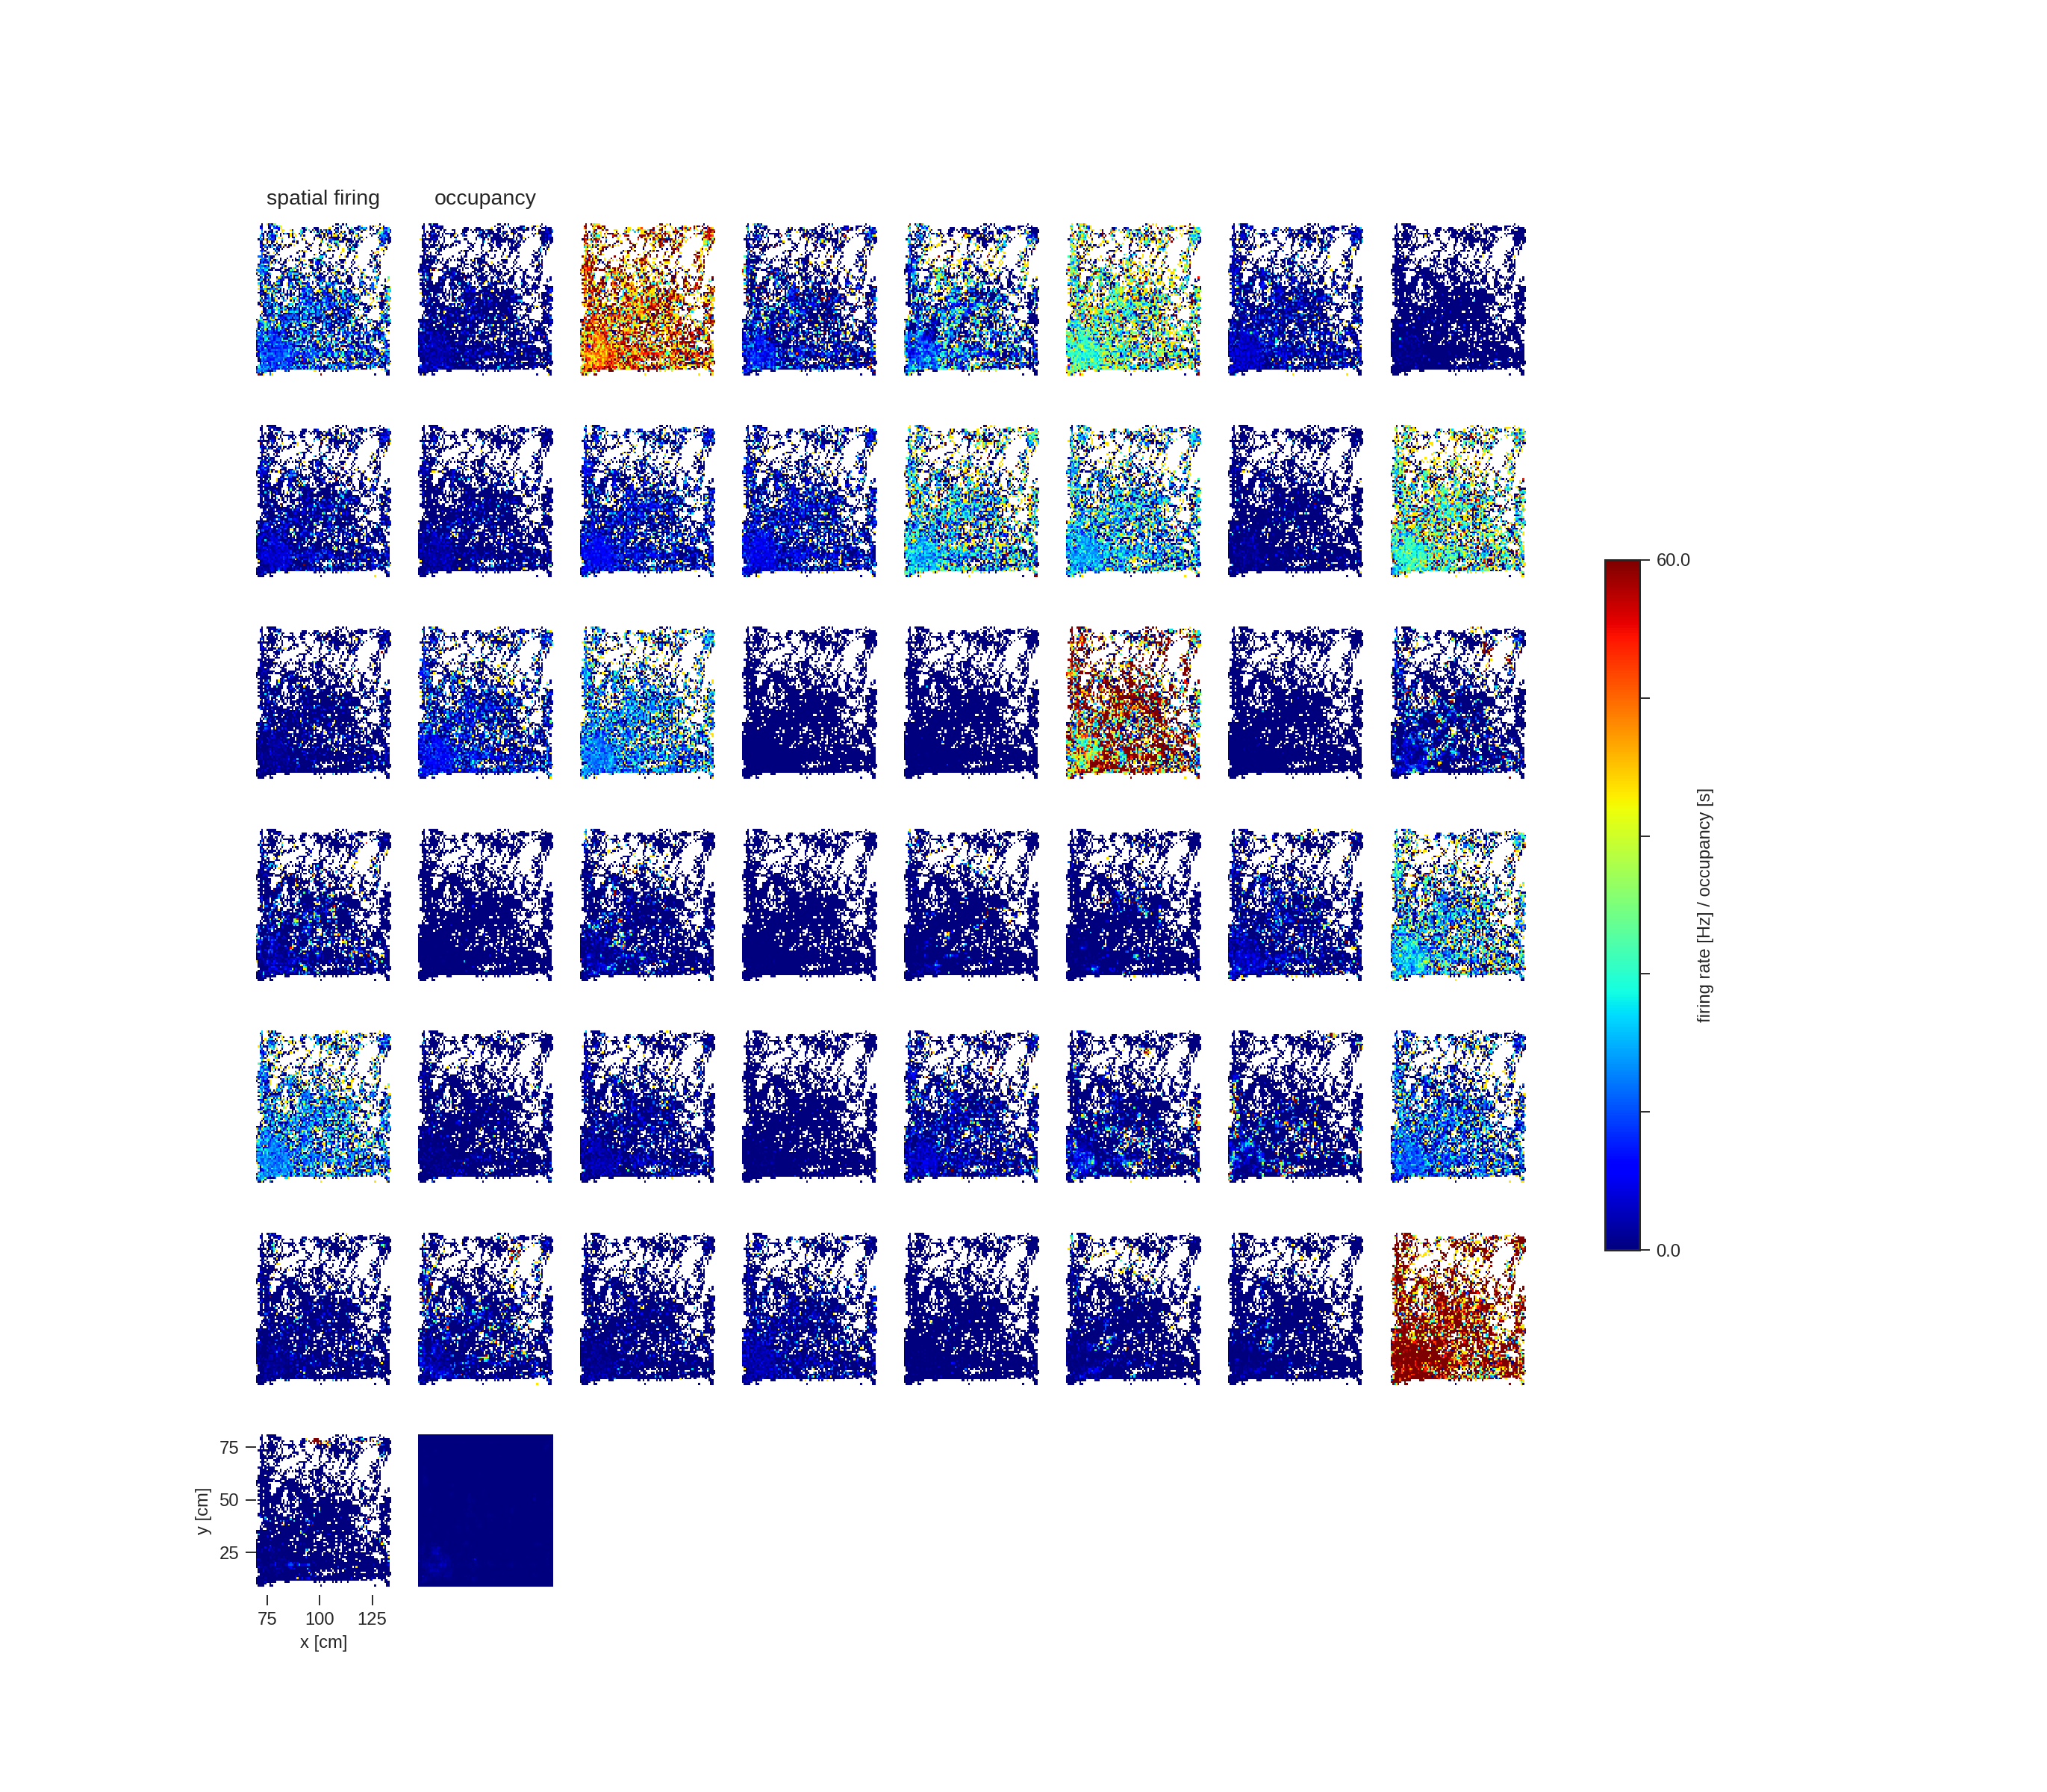

In [90]:
from os import path
from fklab.signals.smooth import create_smoother
import fklab.ratemap as rm
from fklab.plot.plots import plot_2d_maps



cluster_channel = pd.read_csv('/media/kasia/K/Neuropixeldata/data_analysis/Cluster_channel_LS_K_5_140320.tsv', sep='\t')
ks_spike_times = loading.ks_spike_times[:, 0]
spike_time_rangeof = np.array(open_field_epoch) - loading.evt_start_time[1] + time_shift
spike_t = {}
for cl in cluster_channel['cluster']:
    spike_xof = ks_spike_times[loading.get_spike_seq(spike_time_rangeof, cluster_list=[cl] )] + loading.evt_start_time[1]

    spike_t[cl]=spike_xof
    

t_of = corrected_time[np.logical_and(corrected_time > open_field_epoch[0], corrected_time < open_field_epoch[1])]
event = {key: rm.compute_variable_at_times(z, variable=position_of_cm, var_t=t_of) for key, z in spike_t.items()}

eventof = list(event.values())
rmap_hist, _, occ_hist, binedges = rm.hist.ratemap(
    *eventof,
    stimdata = position_of_cm,
    stimduration=1/40,
#     smooth = 5,
#     valid = in_circle(50),
    bins = 80)
 

fig, axes = plot_2d_maps(
        [*rmap_hist,occ_hist],
        coordinates=binedges,
        cmap='jet',
        xlabel="x [cm]",
        ylabel="y [cm]",
        colorlabel="firing rate [Hz] / occupancy [s]",
        cbar=True,
        grid=(None),
#         figsize=(14,3.5),
        axsize=(2,2),
        cmin=0, cmax=60,
        roundto=.5,
        cbar_kw=dict(shrink=0.5)
        )
    
axes[0,0].set(title='spatial firing')
axes[0,1].set(title='occupancy');

for ax in axes.ravel():
        ax.set_frame_on(False)
        ax.axis('equal')
        
        
# fig, axes = plot_2d_maps(
#         [occ_hist],
#         coordinates=binedges,
#         cmap='jet',
#         xlabel="x [cm]",
#         ylabel="y [cm]",
#         colorlabel="firing rate [Hz] / occupancy [s]",
#         cbar=True,
#         grid=(None),
# #         figsize=(14,3.5),
#         axsize=(2,2),
#         cmin=0, cmax='auto',
#         roundto=.5,
#         cbar_kw=dict(shrink=0.5)
#         )
    

# axes[0,0].set(title='occupancy');

# for ax in axes.ravel():
#         ax.set_frame_on(False)
#         ax.axis('equal')

        
        
plt.savefig('/media/kasia/K/Neuropixeldata/LS_k_5/14_03_20_plots/OFratemaps140320_b80.png')

<IPython.core.display.Javascript object>


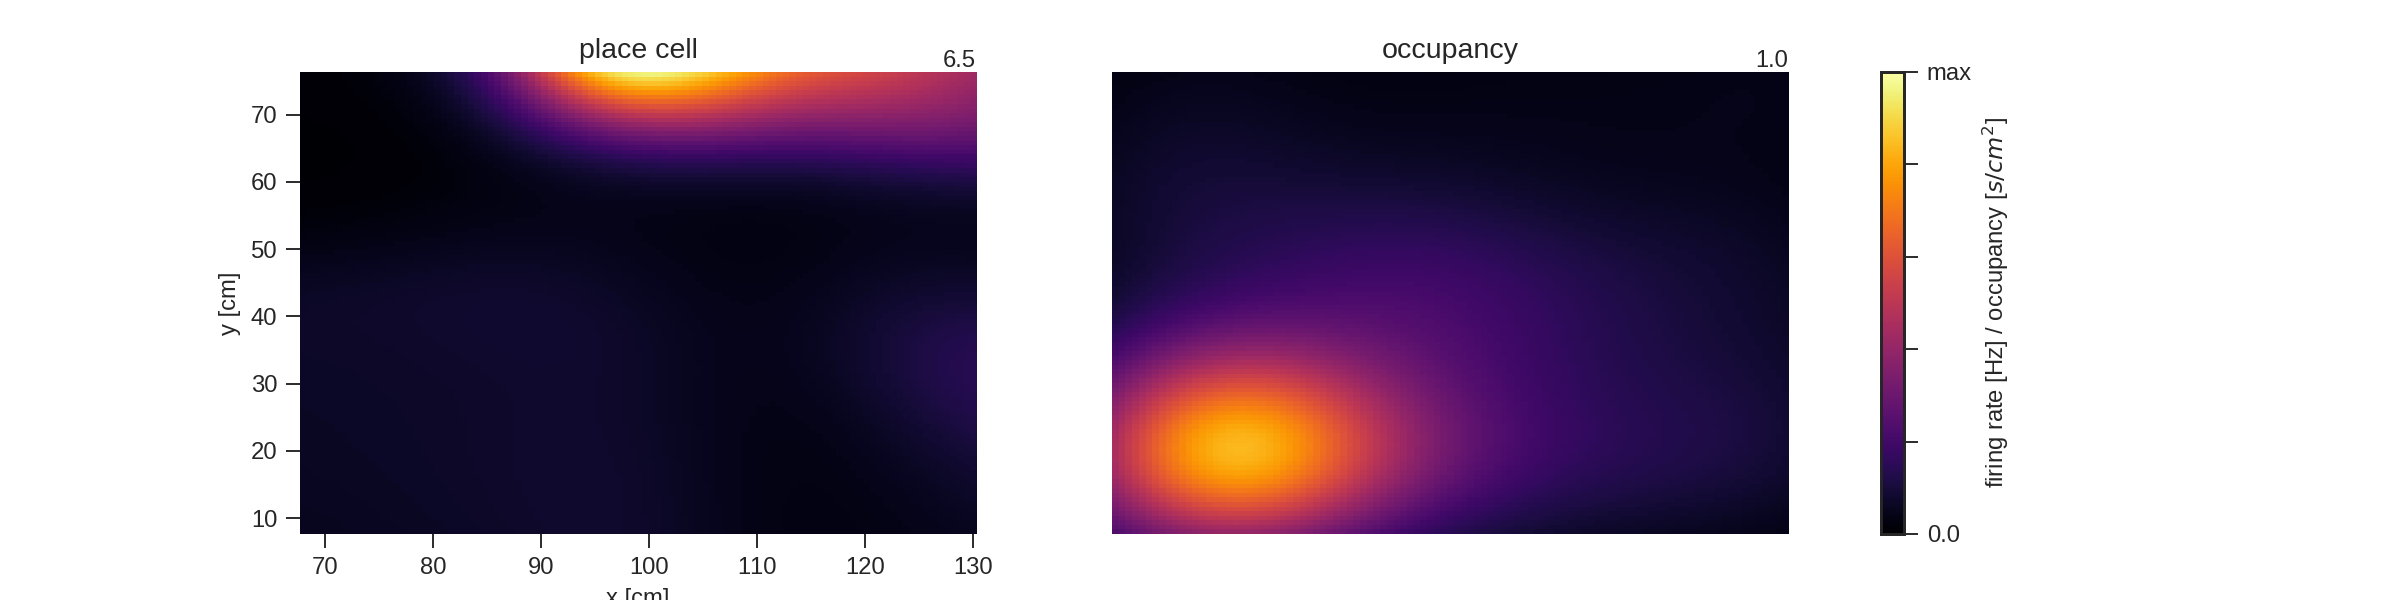

In [57]:
rmap, _, occ, samplegrid = rm.kde.linear_2d_tuning(
    spike_xof, 
    xy = position_of_cm,
    t = t_of,
    bandwidth = 9.,
    grid = [np.linspace(68,130,101), np.linspace(8,76,101)],
#     valid = in_circle(radius=50),
    compression=1.)


fig, axes = plot_2d_maps(
    [*rmap,occ],
    coordinates=samplegrid,
    cmap='inferno',
    xlabel="x [cm]",
    ylabel="y [cm]",
    colorlabel="firing rate [Hz] / occupancy [$s/cm^2$]",
    cbar=True,
    grid=(1,2),
    figsize=(14,3.5),
    cmin=0, cmax='auto',
    roundto=.5
)

axes[0,0].set(title='place cell')
# axes[0,1].set(title='heading cell')
axes[0,1].set(title='occupancy');

for ax in axes[0,:]:
    ax.set_frame_on(False)

In [40]:
 from fklab.behavior.preprocessing import compute_velocity
    
velocity = (position_at_cm[:,0], position_at_cm[:,1])
speed = np.abs(velocity)
print(type(speed))

<class 'numpy.ndarray'>


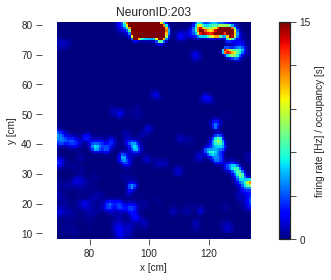

In [403]:
stackxy = np.column_stack([position_of_cm])
eventxy = [rm.compute_variable_at_times(z, variable=stackxy, var_t=t_of)
           for z in [spike_t[203]]]

rmap_hist, _, occ_hist, binedges = rm.hist.ratemap(
    *eventxy,
    stimdata = stackxy,
    stimduration=1/25,
    smooth = 1,
    bins = [np.linspace(69,134,80), np.linspace(8,81,80)])



fig, axes = plot_2d_maps(
    [*rmap_hist],
    coordinates=binedges,
    cmap='jet',
    xlabel="x [cm]",
    ylabel="y [cm]",
    colorlabel="firing rate [Hz] / occupancy [s]",
    cbar=True,
    grid=(None),
    figsize=(5,4),
    cmin=0, cmax= 15,
#     roundto=.5
)

axes[0,0].set(title='NeuronID:203');

for ax in axes.ravel():
    ax.set_frame_on(False)
    ax.axis('equal')

plt.savefig("/media/kasia/K/Neuropixeldata/LS_k_5/14_03_20_plots/Open_field/Rate_map_OF_203_140320.png")

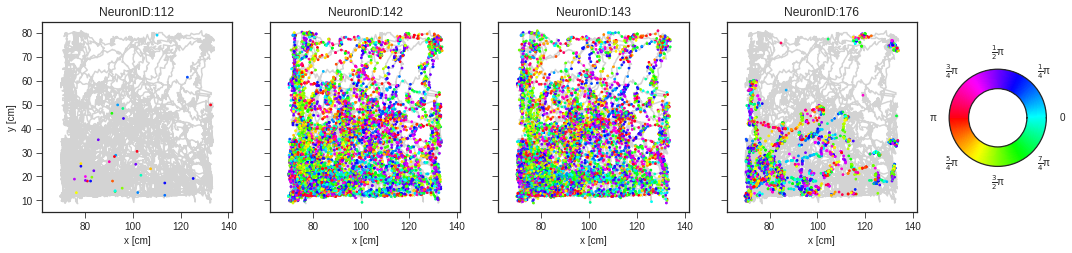

In [395]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

import fklab.ratemap as rm
import fklab.ratemap.utilities
import fklab.behavior.simulation
import fklab.spikes.simulation
import fklab.plot.plots

%matplotlib inline

x=position_of_cm[:,0]
y=position_of_cm[:,1]

xy = np.column_stack([x,y])
dt=1/25
velocity = np.gradient(x,dt)+np.gradient(y,dt)*1.0j
speed = np.abs(velocity)

# compute heading direction
phi = np.angle(velocity)

spike_t1 = {}
spike_t1 = (spike_t[112], spike_t[142], spike_t[143], spike_t[176])


# compute location and heading at time of spikes
simxy = [fklab.ratemap.compute_variable_at_times(k, xy, var_t=t_of)
         for k in spike_t1]
# simxy = {key: rm.compute_variable_at_times(k,xy, var_t=t_of) for key, k in spike_t1.items()}

simphi = [fklab.ratemap.compute_variable_at_times(k, phi, var_t=t_of)
          for k in spike_t1]
# simxy = {key: rm.compute_variable_at_times(k, phi, var_t=t_of) for key, k in spike_t.items()}

celltypes = ['NeuronID:112', 'NeuronID:142', 'NeuronID:143', 'NeuronID:176']

fig, axes = plt.subplots(1, len(celltypes), sharex=False, sharey=True,
                         figsize=(18,3.5),
                         gridspec_kw={'right':0.8})

colscale = matplotlib.colors.Normalize(vmin=-np.pi, vmax=np.pi)

for celltype, _xy, _phi, ax in zip(celltypes, simxy, simphi, axes.ravel()):

    ax.plot(x, y, color='lightgray', zorder=0)

    h = ax.scatter(_xy[:,0], _xy[:,1],
                   c=_phi, s=3, cmap='hsv',
                   norm=colscale)

    ax.axis('equal') # does not work when both sharex and sharey are True :(
    ax.set(xlabel='x [cm]', title=celltype)

axes[0].set(ylabel='y [cm]')

cax = fig.add_axes([0.825, 0, 0.075, 1], polar=True)
fklab.plot.plots.polar_colorbar(cax, rotation=-np.pi, annulus=0.75,
                                show_theta_axis=True, style='math')

plt.savefig("Heading_colormapOF_112_142_143_176_140320.png")


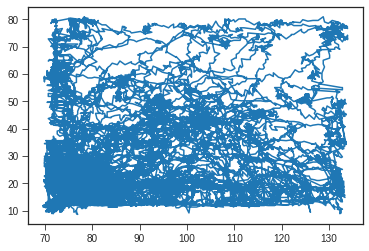

In [335]:
plt.plot(x,y)

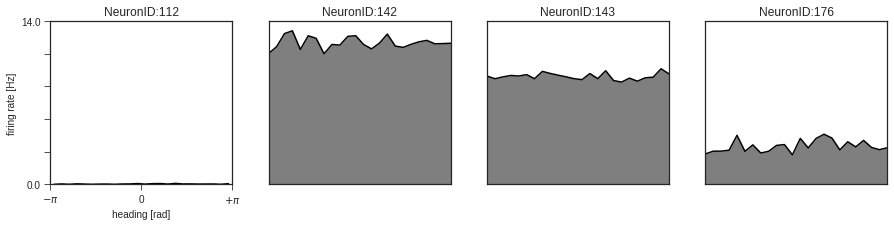

In [404]:
from matplotlib import gridspec
bins = [np.linspace(-np.pi,np.pi,25)]

ratemap, spikecount, occ, grid = rm.hist.general_tuning(
    *spike_t1, stimdata=phi, t=t_of, dt=dt, bins=bins)

fig, axes = fklab.plot.plots.plot_1d_maps(
    ratemap, x=grid[0], sharey=False,
    grid=(None,4), figsize=(15,3), roundto=1,
    xlabel='heading [rad]', ylabel='firing rate [Hz]')


axes[0,0].set_xticks([-np.pi,0,np.pi])
axes[0,0].set_xticklabels([r'$-\pi$', '0', r'$+\pi$']);

for label, ax in zip(celltypes,axes.ravel()):
    ax.set(title=label)

# plt.savefig('Firingrate_heding_112_142_143_176_140320.png')